In [17]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:01<00:00, 92.6MB/s]


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

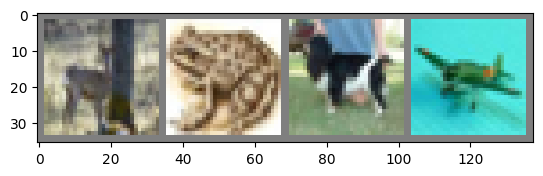

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
# CNN Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)       # 3 input filters, 6 output filters, kernel size of 5x5
        self.pool = nn.MaxPool2d(2, 2)        # kernel size of 2x2, stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5)      # 6 input filters, 16 output filters, kernel size of 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16*5*5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

In [11]:
model = ConvNet().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [2000/12500], Loss: 2.2944
Epoch [1/5], Step [4000/12500], Loss: 2.2952
Epoch [1/5], Step [6000/12500], Loss: 2.2936
Epoch [1/5], Step [8000/12500], Loss: 2.3049
Epoch [1/5], Step [10000/12500], Loss: 2.2917
Epoch [1/5], Step [12000/12500], Loss: 2.3031
Epoch [2/5], Step [2000/12500], Loss: 2.2688
Epoch [2/5], Step [4000/12500], Loss: 1.8893
Epoch [2/5], Step [6000/12500], Loss: 2.2764
Epoch [2/5], Step [8000/12500], Loss: 1.6315
Epoch [2/5], Step [10000/12500], Loss: 1.7247
Epoch [2/5], Step [12000/12500], Loss: 1.7408
Epoch [3/5], Step [2000/12500], Loss: 2.4158
Epoch [3/5], Step [4000/12500], Loss: 1.9704
Epoch [3/5], Step [6000/12500], Loss: 2.3314
Epoch [3/5], Step [8000/12500], Loss: 1.0667
Epoch [3/5], Step [10000/12500], Loss: 1.3469
Epoch [3/5], Step [12000/12500], Loss: 1.4324
Epoch [4/5], Step [2000/12500], Loss: 2.2861
Epoch [4/5], Step [4000/12500], Loss: 1.1038
Epoch [4/5], Step [6000/12500], Loss: 1.0422
Epoch [4/5], Step [8000/12500], Loss: 1.2402
Epoc

In [14]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [15]:
y_true = []  # ground truth labels
y_pred = []  # predicted labels
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 49.42 %
Accuracy of plane: 55.2 %
Accuracy of car: 70.0 %
Accuracy of bird: 43.3 %
Accuracy of cat: 21.0 %
Accuracy of deer: 27.4 %
Accuracy of dog: 55.1 %
Accuracy of frog: 68.8 %
Accuracy of horse: 48.5 %
Accuracy of ship: 58.5 %
Accuracy of truck: 46.4 %


In [19]:
for i in range(10):
  print(f'Index {i} = {classes[i]}')

Index 0 = plane
Index 1 = car
Index 2 = bird
Index 3 = cat
Index 4 = deer
Index 5 = dog
Index 6 = frog
Index 7 = horse
Index 8 = ship
Index 9 = truck


In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.55      0.54      1000
           1       0.56      0.70      0.62      1000
           2       0.35      0.43      0.39      1000
           3       0.39      0.21      0.27      1000
           4       0.46      0.27      0.34      1000
           5       0.41      0.55      0.47      1000
           6       0.48      0.69      0.57      1000
           7       0.67      0.48      0.56      1000
           8       0.58      0.58      0.58      1000
           9       0.57      0.46      0.51      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000

